# Neuronales Netz zum erstellen eines Deepfakes
***

Dieses Dokument ermöglicht Dir, ein Deepfake-Video zu erstellen, wären Du über die Funktion und den Aufbau des dazu verwendeten künstlichen Neuronalen Netzes lernst. 

Es müssen zum Ausführen des Codes folgende Python Module installiert sein: 

***
##### *Das folgende Dokument setzt sich aus folgenden Schritten zusammen:*
1. Einlesen und Aufbereiten von den Daten zum Trainieren
    - Extrahieren von Gesichter aus einem Video
    - Einlesen dieser Daten
2. Initialisieren des künstlichen Neuronalen Netzes
    - Definieren der Struktur des Encoder und Decoder
    - Kombinieren des Encoder und Decoder zu den Autoencodern
    - Kompilieren der Modelle mit einem Optimizer
3. Trainieren
    - Festlegen von Checkpoints für das Trainieren
    - Eigentliches Trainieren des Netzes
4. Fälschen eines neuen Videos
---

## Einlesen und Aufbereiten von den Daten zum Trainieren
***
Um dem künstlichen Neuronalen Netz beizubringen Gesichter zu erkennen und zu erstellen, werden zahlreiche Bilder von Gesichtern benötigt. Im Fall von Deepfakes ist Bildmaterial von zwei Personen nötig. Einfachheitshalber wird als Input Videomaterial verwendet.

### Extrahieren von Gesichter aus einem Video
In den Variablen *PFAD_A* und *PFAD_B* werden die Pfade zu den Videos gespeichert, die dazu verwendet werden Bilder von zwei Personen zu erxtrahieren. Es werden mit der Hilfe der Klasse `Gesichterextrahierer`, die in einer externen Datei definiert wurde, die Gesichter aus den Videos extrahiert. Die Bilder werden in einem Verzeichnis gespeichert.

import Gesichterextrahierer as GE

PFAD_A = './daten/videomaterial/Joe_Biden/nur_joe_biden_gemischt.mp4'
PFAD_B = './daten/videomaterial/Chuck_Norris/nur_Chuck_Norris_gemischt.mp4'
PFAD_KASKADE = './daten/cascades/haarcascade_frontalface_default.xml'

g = GE.Gesichterextrahierer(PFAD_KASKADE)
g.lade(PFAD_A)
g.extrahiereGesichter(
    max_anzahl_bilder=3000,
    ordner_ausgabe='./daten/lernen/Gesichter/A'
)
g.lade(PFAD_B)
g.extrahiereGesichter(
    max_anzahl_bilder=3000,
    ordner_ausgabe='./daten/lernen/Gesichter/B'
)

del PFAD_A, PFAD_B, PFAD_KASKADE, g, GE

### Einlesen der Bilddateien
Dass die Bilder als Datei gespeichert wurden, erspart uns beim nächsten Mal den vorherigen Schritt. Die Dateien müssen nun allerdings wieder ins Programm geladen werden.

> `erstelleDatensatz(pfad: str) -> list[list]`
>
> Lädt alle Bilder in dem übergebenen Verzeichnis in zwei Datensätze und gibt diese als Liste zurück. Jeder Pixelwert wird durch 255 geteilt, um die Werte auf den Bereich zwischen 0 und 1 zu projektieren. Dies stellt sicher, dass die Werte des künstlischen Neuronale Netzes (KNN), wenn das Bild übergeben wird, nicht zu groß werden. Die Bilder werden in zwei Datensätze umgewandelt, zu 75% zum Trainieren des KNN und zu 25% zum Prüfen und Bewerten der Leistung des Netzes.

> `def teileListe(liste: list, verteilung: float) -> list[list]`
>
> Teilt die übergebene Liste in zwei Listen und gibt diese zurück. Die erste zurückgegebene Liste hat ein Länge von _n_-% der übergebenen Liste, wobei _n_ als Kommazahl zwischen 1 und 0 mit `verteilung` übergeben wird. 

In [1]:
import numpy as np
import cv2
import os

def erstelleDatensatz(pfad: str, anzahl: int) -> list:
    bilder = []
    for wurzel, ordner, dateien in os.walk(pfad):
        for datei in dateien:
            if datei.split(".")[-1].lower() not in ['png', 'jpg', 'jpeg']: continue
            bild = cv2.imread(os.path.join(wurzel, datei))
            #bild = cv2.pyrDown(bild)
            bild = bild.astype('float32')
            bild /= 255.0
            bilder.append(bild)
            if len(bilder) >= anzahl: break
            bilder.append(np.fliplr(bild))
            if len(bilder) >= anzahl: break
    np.random.shuffle(bilder)
    bilder_train, bilder_test = teileListe(bilder, 0.75)
    bilder_train, bilder_test = np.array(bilder_train), np.array(bilder_test)
    print('%d Bilder aus %s geladen.' % (len(bilder), pfad))
    return [bilder_train, bilder_test]

def teileListe(liste: list, verteilung: float) -> list:
    x = int(len(liste)*verteilung)
    return [liste[:x], liste[x:]]

def verzerren(bild: list, staerke: int):
    hoehe = bild.shape[0]
    breite = bild.shape[1]
    punkte_von = np.float32([[0, 0], [0, hoehe], [breite, 0], [breite, hoehe]])
    punkte_nach = np.float32([[0, staerke], [0, hoehe-staerke], [breite, 0], [breite, hoehe]])
    matrix = cv2.getPerspectiveTransform(punkte_von, punkte_nach)
    bild_verzerrt = cv2.warpPerspective(bild, matrix, (breite, hoehe))
    bild_verzerrt = bild_verzerrt[staerke:hoehe-staerke, staerke:breite-staerke]
    return cv2.resize(bild_verzerrt, (breite, hoehe))

datensatz_gesichter_A_train, datensatz_gesichter_A_test = erstelleDatensatz('daten/lernen/Gesichter/A', 5000)
NAME_AUTOENCODER_A = 'Biden'

datensatz_gesichter_B_train, datensatz_gesichter_B_test = erstelleDatensatz('daten/lernen/Gesichter/B', 5000)
NAME_AUTOENCODER_B = 'Trump'

5000 Bilder aus daten/lernen/Gesichter/A geladen.
5000 Bilder aus daten/lernen/Gesichter/B geladen.


**Um zu prüfen, ob dies geklappt hat, wird hier ein beispielhaftes Bild dargestellt.**

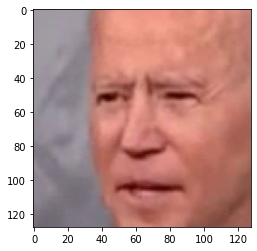

In [2]:
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(cv2.cvtColor(datensatz_gesichter_A_test[6], cv2.COLOR_BGR2RGB))

## Initialisieren des Neuronalen Netzes
***
Nun wird das künstlichen Neuronale Netz initialisiert. Dazu wird die Struktur des Netzes definiert und das Modell anschließend kompiliert.

### Definieren der Struktur des Encoder und Decoder

In [3]:
import tensorflow as tf

IMG_SHAPE = (128, 128, 3)
NAME = "CNN_V2"

def logSummary(string: str):
    with open(f"./daten/modelle/{NAME}/modell.info", "a") as datei:
        datei.write(string + "\n")

def gibEncoder():
    encoder = tf.keras.Sequential(name='encoder')
    encoder.add(tf.keras.layers.Conv2D(16, kernel_size=5, strides=2, padding='same', input_shape=( IMG_SHAPE ) ))
    encoder.add(tf.keras.layers.Conv2D(16, kernel_size=5, strides=2, padding='same'))
    encoder.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same'))
    encoder.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
    encoder.add(tf.keras.layers.Flatten())
    encoder.add(tf.keras.layers.Dense( 200 ))
    
    encoder.summary(print_fn=logSummary)
    print(encoder.summary())
    return encoder

def gibDecoder():
    decoder = tf.keras.Sequential(name='decoder')
    decoder.add(tf.keras.layers.Dense( (8*8*64), input_shape=(200,)))
    decoder.add(tf.keras.layers.Reshape( (8, 8, 64) ))
    decoder.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(16, kernel_size=5, strides=2, padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(16, kernel_size=5, strides=2, padding='same'))
    decoder.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=1))
    
    decoder.summary(print_fn=logSummary)
    print(decoder.summary())
    return decoder

### Kombinieren des Encoder und Decoder zu den Autoencodern

In [4]:
def gibAutoencoder(name):
    x = tf.keras.layers.Input( shape=IMG_SHAPE, name='input_layer' )
    encoder, decoder = gibEncoder(), gibDecoder()
    autoencoder = tf.keras.Model(x, decoder(encoder(x)), name=name)
    
    print(autoencoder.summary())
    return autoencoder

### Kompilieren der Modelle mit einem Optimizer

In [5]:
OPTIMIZER_FUNKTION = tf.keras.optimizers.Adam(learning_rate=1e-5)
LOSS_FUNKTION = tf.keras.losses.MeanSquaredError()

def gibKompiliertenAutoencoder(name):
    autoencoder = gibAutoencoder(name)
    autoencoder.compile(optimizer=OPTIMIZER_FUNKTION, loss=LOSS_FUNKTION)
    
    return autoencoder

In [6]:
try:
    autoencoder_A = tf.keras.models.load_model(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/")
    autoencoder_B = tf.keras.models.load_model(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/")
    print("Modelle von der Festplatte geladen.\n")
except:
    try:
        os.mkdir(f"./daten/modelle/{NAME}/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/Bilder/")
        os.mkdir(f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/Bilder/")
    except FileExistsError:
        pass
    autoencoder_A = gibKompiliertenAutoencoder(name="autoencoder_A")
    autoencoder_B = gibKompiliertenAutoencoder(name="autoencoder_B")
    
loss = autoencoder_A.evaluate(datensatz_gesichter_A_test[:32], datensatz_gesichter_A_test[:32])
print(f"Aktueller Loss von A ({NAME_AUTOENCODER_A}): {loss}")

loss = autoencoder_B.evaluate(datensatz_gesichter_B_test[:32], datensatz_gesichter_B_test[:32])
print(f"Aktueller Loss von B ({NAME_AUTOENCODER_B}): {loss}")

2021-11-05 17:16:15.452922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:16:15.503035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:16:15.503228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:16:15.503747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Modelle von der Festplatte geladen.



2021-11-05 17:16:17.178146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 17:16:17.814342: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-05 17:16:18.092741: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step - loss: 0.0010
Aktueller Loss von A (Biden): 0.0010287099285051227
1/1 [==============================] - 0s 97ms/step - loss: 0.0012
Aktueller Loss von B (Trump): 0.0011878936784341931


## Trainieren
***

### Festlegen von Checkpoints für das Trainieren

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
import LoggingCallback as lc


autoencoder_A_logging_callback = lc.LoggingCallback(
    pfad_modell=f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/",
    bild_A=datensatz_gesichter_A_test[1],
    bild_B=datensatz_gesichter_B_test[1]
)

autoencoder_B_logging_callback = lc.LoggingCallback(
    pfad_modell=f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/",
    bild_A=datensatz_gesichter_A_test[1],
    bild_B=datensatz_gesichter_B_test[1]
)

autoencoder_A_checkpoint_callback = ModelCheckpoint(
    f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_A}/",
    monitor='val_loss',
    save_best_only=True
)

autoencoder_B_checkpoint_callback = ModelCheckpoint(
    f"./daten/modelle/{NAME}/{NAME_AUTOENCODER_B}/",
    monitor='val_loss',
    save_best_only=True
)

### Eigentliches Trainieren des Netzes

In [8]:
import time, gc

ZEITPUNKT_ENDE = time.time() + int(8*60*60)

while time.time() < ZEITPUNKT_ENDE:
    print("!- Noch für ~{:.2f}h beschäftigt.".format(( ZEITPUNKT_ENDE-time.time() )/3600) )
    
    autoencoder_A.fit(
                      datensatz_gesichter_A_train,
                      datensatz_gesichter_A_train,
                      epochs=1,
                      batch_size=16,
                      shuffle=True,
                      validation_data=(datensatz_gesichter_A_test, datensatz_gesichter_A_test),
                      callbacks=[autoencoder_A_checkpoint_callback, autoencoder_A_logging_callback]
                     )
    autoencoder_B.layers[1] = autoencoder_A.get_layer('encoder')
    gc.collect()
    
    autoencoder_B.fit(
                      datensatz_gesichter_B_train,
                      datensatz_gesichter_B_train,
                      epochs=1,
                      batch_size=16,
                      shuffle=True,
                      validation_data=(datensatz_gesichter_B_test, datensatz_gesichter_B_test),
                      callbacks=[autoencoder_B_checkpoint_callback, autoencoder_B_logging_callback]
                     )
    autoencoder_A.layers[1] = autoencoder_B.get_layer('encoder')
    gc.collect()

!- Noch für ~8.00h beschäftigt.


2021-11-05 17:16:18.864581: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 737280000 exceeds 10% of free system memory.
2021-11-05 17:16:19.146019: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 737280000 exceeds 10% of free system memory.
2021-11-05 17:16:19.430260: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 737280000 exceeds 10% of free system memory.
2021-11-05 17:16:19.626048: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 737280000 exceeds 10% of free system memory.


121/235 [==============>...............] - ETA: 2s - loss: 0.0011

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


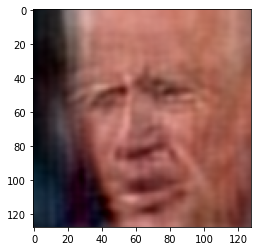

In [13]:
imshow(cv2.cvtColor(autoencoder_A.predict(datensatz_gesichter_B_test[6].reshape(1, 128, 128, 3))[0], cv2.COLOR_BGR2RGB))

In [14]:
import Gesichterextrahierer as GE

PFAD_KASKADE = './daten/cascades/haarcascade_frontalface_default.xml'

def fake(bild):
    global autoencoder_B
    bild = bild.astype('float32')
    bild /= 255.0
    erg = autoencoder_B.predict(bild.reshape(1, 128, 128, 3))[0]
    erg *= 255.0
    return erg

g = GE.Gesichterextrahierer(PFAD_KASKADE)
g.lade('./biden.mp4')
g.fuerGesichterMache(fake, 10000, True)

Es wurden erfolgreich 786 Bilder bearbeitet.

787